# EE4375: Seventh Lab Session: Two Dimensional Finite Element Simulation of an Inductor

The **goals** of this seventh lab session of the [EE4375 Course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) is to apply the two-dimensional finite element to the computation of the magnetic field caused by the curent flowing through the coil of wounded around the middle leg of a three-legged inductor. 

The lab session goes through the **five steps** typical of a finite element solution procedure. In the **first** step, the geometry of the configuration is generated. Here we consider the cross-section the ferromagnetic core with the multi-turn coil encircling the middle core leg. The geometry thus consists of three subdomain. The first subdomain in the ferromagnetic core subdomain. The second subdomain is the air subdomain. The third subdomain is the third subdomain. This latter subdomain is subdivided in two parts, each corresponding to a direction of the applied current density. The mesh is generated using geometry primitives that GMSH provided. In the **second** step, the mesh is generated using the geometry as input. The mesh is generated using a a variant of the Delaunay method. In this method the interior and exterior boundaries of the geometries are meshes first. The boundary mesh is subsequently advanced into the interior of the domain. In the **third** step, the physics consisting of the partial differential equation and boundary conditions in imposed on the mesh. Here we impose the physics of a perpendicular current generating a magnetic field. The z-component of the magnetic vector potential is solved for. In the **fourth** step, the discrete linear problem is assembled by a loop over the elements and solved by a sparse direct solver. First order linear Lagrange shape functions on an unstructured mesh of triangular elements is employed. In the **fifth** and final step, the computed solution is written to a VTK file allowing visualization using e.g. Paraview. 

## Import Packages

In [22]:
try
    using Gmsh: gmsh
catch
    using gmsh
end

using LinearAlgebra 
using SparseArrays 
using StaticArrays
using StaticRanges

using BenchmarkTools

using Test 

using Plots
using GR 

## Section 1: Define Mesh Struct and Auxilary Function

In [23]:
# struct to hold 2D point
struct Point
  x::Float64   # x coordinates
  y::Float64   # y coordinates 
end

# struct to the physics per element 
struct Physics 
  reluctivity::Float64   
  conductivity::Float64  
  currdensity::Float64
end

# struct to hold a single mesh element
# compared to 6-lab-session, we extend with physical properties on the element 
struct Element
  p1::Point       # coordinates first node 
  p2::Point       # coordinates second node 
  p3::Point       # coordinates third node     
  e1::Int64       # global index first node
  e2::Int64       # global index second node
  e3::Int64       # global index third node
  area::Float64   # area of the element 
  physics::Physics 
end

# struct to hold entire mesh
struct Mesh
  nnodes::Int64               # number of nodes 
  nelems::Int64               # number of elements
  Elements::Array{Element,1}  # list of Elements 
  bndNodeIds::Vector{Int64}   # indices of nodes where Dirichlet bc are applied  
  dofPerElem::Int64           # number of dofs per element 
end

In [44]:
#..sets the source on each group of elements of the mesh 
#..sets the current density in the left (positive) and right (negative) side of the winding
#..the current density is zero on the air and coil domain
#..the source is set to be constant on each element in the mesh 
curr_dens_value = 1e4; 
sourcefunction(group_id) = curr_dens_value*(group_id==4)-curr_dens_value*(group_id==5)

#..sets the reluctivity on each group of elements of the mesh 
#..sets the reluctivity in the ferromagnetic core
#..the reluctivity is set to one on the coil and air domain 
#..the reluctivity is set to be constant on each element in the mesh 
mu0 = 4*pi*1e-7
mur = 1000; 
reluctivityfunction(group_id) = (1/mu0)*((group_id==1)+(group_id==4)+(group_id==5))+(1/(mu0*mur))*((group_id==2)+mur*(group_id==3))

reluctivityfunction (generic function with 1 method)

In [45]:
# compute the area of the triangle with vertices p1, p2 and p3
# same as 6-lab-session 
function area_triangle(p1,p2,p3)    
    x12 = p2.x - p1.x; x13 = p3.x-p1.x;
    y12 = p2.y - p1.y; y13 = p3.y-p1.y;
    area_id = x12*y13 - x13*y12; 
    area_id = abs(area_id)/2.
    return area_id 
end

area_triangle (generic function with 1 method)

## Section 2: Read Mesh From File and Store Mesh in Struct

In [46]:
# group elements in coil, core and air domain 
function groupElements!(e_group,gmshModel)

    #..Get elements from the mesh (more)
    element_types, element_ids, element_connectivity = gmshModel.mesh.getElements(2)
    nelems = length(element_ids[1])
     
    #..Get nodes from physical subdomains (more)
    ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 401)
    ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 402)
    ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 403)
    ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 404)
    ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 405)

    #..Set group number on each element
    for element_id in 1:nelems
        node1_id = element_connectivity[1][3*(element_id-1)+1]
        node2_id = element_connectivity[1][3*(element_id-1)+2]
        node3_id = element_connectivity[1][3*(element_id-1)+3]
        G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) #air
        G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) #upper core
        G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) #lower core
        G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) #winding right
        G5 = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) #winding left
        if G1 == 3
           e_group[element_id] = 1;
        elseif G2 == 3 || G3 == 3
           e_group[element_id] = 2;
        elseif G4 == 3
           e_group[element_id] = 4;
        elseif G5 == 3
           e_group[element_id] = 5;
        end
        
        if (false)
           println("on element ", element_id, " e_group[element_id] = ", e_group[element_id])
        end
     end 
     return e_group 
end

groupElements! (generic function with 1 method)

In [47]:
# read elements from mesh file 
# still to be improved for type-stability 
function meshFromGmsh(meshFile)    
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Get the mesh elements
    #..Observe that we get all the two-dimensional triangular elements from the mesh
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelems = length(element_ids[1])

    e_group = zeros(nelems)
    e_group = groupElements!(e_group,gmsh.model)
    reluctivityperelement = map(reluctivityfunction, e_group)    
    sourceperelement = map(sourcefunction, e_group)

    #..Construct uninitialized array of length nelements  
    Elements = Array{Element}(undef,nelems)

    #..Construct the array of elements 
    for element_id in 1:nelems
        e1 = element_connectivity[1][3*(element_id-1)+1]
        e2 = element_connectivity[1][3*(element_id-1)+2]
        e3 = element_connectivity[1][3*(element_id-1)+3]
        p1 = Point(sorted[e1,2], sorted[e1,3])
        p2 = Point(sorted[e2,2], sorted[e2,3])
        p3 = Point(sorted[e3,2], sorted[e3,3])
        area = area_triangle(p1,p2,p3); 
        physics = Physics(reluctivityperelement[element_id], 1., sourceperelement[element_id])
        Elements[element_id] = Element(p1,p2,p3,e1,e2,e3,area,physics)
    end

    #..retrieve boundary nodes by loop over corner point and boundary edges
    node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
    node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
    node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
    node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
    node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
    node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
    node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,101)
    node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,102)
    node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,103)
    node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,104)
    bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
    
    #..Set DOF per element
    dofPerElement = 9 
    
    #..Store data inside mesh struct  
    mesh = Mesh(nnodes,nelems,Elements,bnd_node_ids,dofPerElement) 
    
    #..Finalize gmsh
    gmsh.finalize()
    
    return mesh 
end

#..read nodes from mesh file (useful for post-processing)
function nodesFromGmsh(meshFile)
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Finalize gmsh
    gmsh.finalize()
    
    return xnode,ynode 
end

nodesFromGmsh (generic function with 1 method)

In [48]:
mesh = meshFromGmsh("data/inductor-coarse.msh");

Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'


In [49]:
display(mesh)

Mesh(828, 1550, Element[Element(Point(27.25, 2.990461453270688), Point(27.25, 0.35), Point(29.6507800431675, 1.670230726635344), 128, 8, 281, 3.169583580882662, Physics(795774.7154594767, 1.0, 0.0)), Element(Point(41.53120983188307, 25.00091938442123), Point(37.0518074479306, 27.78558163191715), Point(37.71198003224049, 22.35841036779123), 326, 280, 328, 11.236063113142205, Physics(795774.7154594767, 1.0, 0.0)), Element(Point(30.49999999999668, -31.09999999999679), Point(34.8529800219132, -29.86041743770032), Point(30.90820693460608, -25.71064984440382), 225, 266, 334, 11.476863680229274, Physics(795774.7154594767, 1.0, 0.0)), Element(Point(45.33129515526653, -7.244746233870147), Point(40.4732417013907, -5.886387288981842), Point(41.28232998897512, -10.36828166739157), 310, 296, 320, 10.337125076147696, Physics(795774.7154594767, 1.0, 0.0)), Element(Point(29.62659184928147, 40.81591459681277), Point(32.49999999999839, 45.6698729810869), Point(27.36678341143361, 45.35640966351416), 302,

## Section 3: FEM Assembly 

### Section 1.3: Stiffness Matrix Assembly

In [50]:
function genLocStiffMat(element::Element)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    reluctivity = element.physics.reluctivity 
    area = element.area 
    Iloc = SVector(e1, e1, e1, e2, e2, e2, e3, e3, e3)
    Jloc = SVector(e1, e2, e3, e1, e2, e3, e1, e2, e3)
    Xmat = SMatrix{3,3}(p1.x, p2.x, p3.x, p1.y, p2.y, p3.y, 1, 1, 1) 
    rhs  = SMatrix{3,3}(1., 0., 0., 0., 1., 0., 0., 0., 1.) 
    Emat = MMatrix{3,3}(Xmat\rhs);
    Emat[3,:] .= 0.;  
    Amat = SMatrix{3,3}(area*reluctivity*(transpose(Emat)*Emat));
    Aloc = [Amat[1,:] ; Amat[2,:] ; Amat[3,:] ] 
    return Iloc, Jloc, Aloc
end

function genStiffMat(mesh::Mesh)
 
    #..recover number of elements  
    nelems     = mesh.nelems 
    dofPerElem = mesh.dofPerElem;
     
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofPerElem*nelems)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues)) 

    for i = 1:nelems #..loop over number of elements..
        element          = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocStiffMat(element)
        irng             = mrange(dofPerElem*i-8, dofPerElem*i) 
        I[irng]          = Iloc 
        J[irng]          = Jloc 
        Avalues[irng]    = Aloc         
    end
    
    A = sparse(I,J,Avalues)
   
    return A; 
end

genStiffMat (generic function with 1 method)

In [51]:
mesh = meshFromGmsh("data/inductor-coarse.msh"); @btime A = genStiffMat(mesh); # <= force recompilation
mesh = meshFromGmsh("data/inductor-coarse.msh"); @btime A = genStiffMat(mesh)
mesh = meshFromGmsh("data/inductor-normal.msh"); @btime A = genStiffMat(mesh); 
mesh = meshFromGmsh("data/inductor-fine.msh"); @btime A = genStiffMat(mesh);

Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
  121.583 μs (20 allocations: 652.81 KiB)
Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
  121.292 μs (20 allocations: 652.81 KiB)
Info    : Reading 'data/inductor-normal.msh'...
Info    : 75 entities
Info    : 5887 nodes
Info    : 11648 elements
Info    : Done reading 'data/inductor-normal.msh'
  1.029 ms (23 allocations: 4.76 MiB)
Info    : Reading 'data/inductor-fine.msh'...
Info    : 75 entities
Info    : 48540 nodes
Info    : 96902 elements
Info    : Done reading 'data/inductor-fine.msh'
  9.596 ms (23 allocations: 39.56 MiB)


### Section 2.3: Mass Matrix Assembly

In [52]:
function genLocMassMat(element::Element)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    conductivity = element.physics.conductivity
    area = element.area 
    Iloc = SVector(e1, e1, e1, e2, e2, e2, e3, e3, e3)
    Jloc = SVector(e1, e2, e3, e1, e2, e3, e1, e2, e3)
    Mloc = SMatrix{3,3}(area*conductivity/3, 0., 0., 0., area*conductivity/3, 0., 0., 0., area*conductivity/3) 
    return Iloc, Jloc, Mloc
end

function genMassMat(mesh::Mesh)
 
    #..recover number of elements  
    nelems     = mesh.nelems 
    dofPerElem = mesh.dofPerElem;
     
    #..preallocate the memory for local matrix contributions 
    Mvalues = zeros(Float64,dofPerElem*nelems)
    I = zeros(Int64,length(Mvalues))
    J = zeros(Int64,length(Mvalues)) 

    for i = 1:nelems #..loop over number of elements..
        element          = mesh.Elements[i]
        Iloc, Jloc, Mloc = genLocMassMat(element)
        irng             = mrange(dofPerElem*i-8, dofPerElem*i) 
        I[irng]          = Iloc 
        J[irng]          = Jloc 
        Mvalues[irng]    = Mloc         
    end
    
    M = sparse(I,J,Mvalues)
   
    return M; 
end

genMassMat (generic function with 1 method)

In [53]:
mesh = meshFromGmsh("data/inductor-coarse.msh"); @btime M = genMassMat(mesh); # <= force recompilation 
mesh = meshFromGmsh("data/inductor-coarse.msh"); @btime M = genMassMat(mesh)
mesh = meshFromGmsh("data/inductor-normal.msh"); @btime M = genMassMat(mesh); 
mesh = meshFromGmsh("data/inductor-fine.msh"); @btime M = genMassMat(mesh);

Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
  114.917 μs (20 allocations: 652.81 KiB)
Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
  114.208 μs (20 allocations: 652.81 KiB)
Info    : Reading 'data/inductor-normal.msh'...
Info    : 75 entities
Info    : 5887 nodes
Info    : 11648 elements
Info    : Done reading 'data/inductor-normal.msh'
  978.917 μs (23 allocations: 4.76 MiB)
Info    : Reading 'data/inductor-fine.msh'...
Info    : 75 entities
Info    : 48540 nodes
Info    : 96902 elements
Info    : Done reading 'data/inductor-fine.msh'
  9.304 ms (23 allocations: 39.56 MiB)


### Section 3.3: Right-Hand Side Assembly

In [54]:
function genLocVector(element::Element)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3; 
    currdensity = element.physics.currdensity 
    area = element.area 
    Iloc = SVector(e1, e2, e3) 
    # use broadcast for the lines below instead 
    floc = SVector(area/3*currdensity, area/3*currdensity, area/3*currdensity) 
    return Iloc, floc
end

function genVector(mesh)  
 
    #..recover number of elements  
    nelems  = mesh.nelems 
    nnodes = mesh.nnodes 
     
    #..preallocate the memory for local matrix contributions 
    f = zeros(Float64,nnodes)

    for i = 1:nelems #..loop over number of elements..
        element::Element = mesh.Elements[i]
        Iloc, floc = genLocVector(element)
        f[Iloc] += floc 
    end
       
    return f; 
end

genVector (generic function with 1 method)

In [55]:
mesh = meshFromGmsh("data/inductor-coarse.msh"); @btime f = genVector(mesh); # <= force recompilation
mesh = meshFromGmsh("data/inductor-coarse.msh"); @btime f = genVector(mesh)
mesh = meshFromGmsh("data/inductor-normal.msh"); @btime f = genVector(mesh); 
mesh = meshFromGmsh("data/inductor-fine.msh"); @btime f = genVector(mesh);

Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
  3.099 μs (1 allocation: 6.62 KiB)
Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
  3.068 μs (1 allocation: 6.62 KiB)
Info    : Reading 'data/inductor-normal.msh'...
Info    : 75 entities
Info    : 5887 nodes
Info    : 11648 elements
Info    : Done reading 'data/inductor-normal.msh'
  21.083 μs (2 allocations: 46.05 KiB)
Info    : Reading 'data/inductor-fine.msh'...
Info    : 75 entities
Info    : 48540 nodes
Info    : 96902 elements
Info    : Done reading 'data/inductor-fine.msh'
  224.167 μs (2 allocations: 379.30 KiB)


## Section 4: FEM Solve  

### Section 1.4: Handle Dirichlet Essential Boundary Conditions 

In [56]:
function handleBoundary!(mesh,A,f)
    bndNodeIds = mesh.bndNodeIds; 
    #..handle essential boundary conditions 
    A[bndNodeIds,:] .= 0;
    A[bndNodeIds,bndNodeIds] = Diagonal(ones(size(bndNodeIds)))
    f[bndNodeIds] .= 0;
    return A, f  
end

handleBoundary! (generic function with 1 method)

In [57]:
mesh = meshFromGmsh("data/inductor-coarse.msh"); A = genStiffMat(mesh); f = genVector(mesh);
A,f = handleBoundary!(mesh,A,f);

Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'


### Section 2.4: Solve Linear System 

In [58]:
function genSolution!(mesh,A,f)
    A, f = handleBoundary!(mesh,A,f)
    u = A\f 
    return u 
end

genSolution! (generic function with 1 method)

Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
Info    : Reading 'data/inductor-coarse.msh'...
Info    : 75 entities
Info    : 828 nodes
Info    : 1550 elements
Info    : Done reading 'data/inductor-coarse.msh'
  0.000330 seconds (21 allocations: 652.859 KiB)
  0.004529 seconds (83 allocations: 1.664 MiB)


GKS: Viewport is not within the NDC unit square in routine SET_VIEWPORT


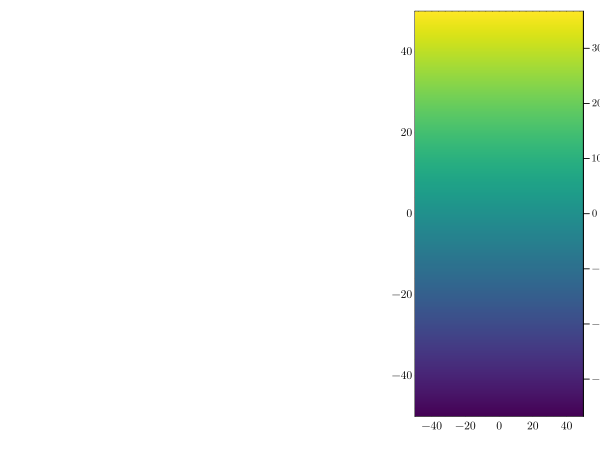

In [62]:
mesh = meshFromGmsh("data/inductor-coarse.msh");  
xnode,ynode = nodesFromGmsh("data/inductor-coarse.msh")
@time A = genStiffMat(mesh); f= genVector(mesh); 
@time u = genSolution!(mesh,A,f)
GR.tricont(xnode,ynode,u)

## Section 4: Post-Processing for the Magnetic Flux 

In [60]:
function genDerivLoc(element::Element,u)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    area = element.area 
    uloc1 = u[e1]; uloc2 = u[e2]; uloc3 = u[e3]; 
    Xmat = SMatrix{3,3}(p1.x, p2.x, p3.x, p1.y, p2.y, p3.y, 1, 1, 1) 
    rhs  = SMatrix{3,3}(1., 0., 0., 0., 1., 0., 0., 0., 1.) 
    Emat = MMatrix{3,3}(Xmat\rhs);
    Emat[3,:] .= 0.; 
    xmid = (p1.x+p2.x+p3.x)/3
    ymid = (p1.y+p2.y+p3.y)/3
    Bx = uloc1*Emat[2,1]+uloc2*Emat[2,2]+uloc3*Emat[2,3]
    By = uloc1*Emat[1,1]+uloc2*Emat[1,2]+uloc3*Emat[1,3]
    normB2 = Bx^2 + By^2 
    return xmid, ymid, Bx, By, normB2
end

function genDeriv(mesh, u)

    #..recover number of elements  
    nelems  = mesh.nelems 
    nnodes = mesh.nnodes 

    #..allocate memory for arrays 
    xmid = zeros(nelems,1)
    ymid = zeros(nelems,1)
    Bx = zeros(nelems,1)
    By = zeros(nelems,1)
    normB2 = zeros(nelems,1)

    for element_id in 1:nelems
        element::Element = mesh.Elements[element_id]
        xmid[element_id], ymid[element_id], Bx[element_id], By[element_id], normB2[element_id] = genDerivLoc(element,u) 
    end 
    
    return xmid, ymid, Bx, By, normB2 
end

genDeriv (generic function with 1 method)

GKS: Viewport is not within the NDC unit square in routine SET_VIEWPORT


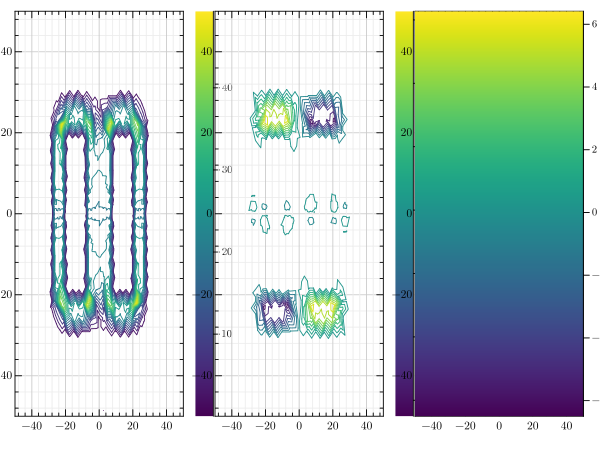

In [61]:
xmid, ymid, Bx, By, normB2 = genDeriv(mesh, u)
GR.subplot(1,3,1)
p1 = GR.tricont(xmid,ymid,normB2)
GR.subplot(1,3,2)
p1 = GR.tricont(xmid,ymid,Bx)
GR.subplot(1,3,3)
p1 = GR.tricont(xmid,ymid,By)